# MTL

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim

In [3]:
class SharedAttentionLayer(nn.Module):
    def __init__(self, d_model, nhead, dropout=0.1):
        super().__init__()
        # We use PyTorch's built-in MultiheadAttention
        self.multihead_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
    
    def forward(self, x):
        """
        x shape: (seq_len, batch_size, d_model)
        Returns: (seq_len, batch_size, d_model)
        """
        # Queries, Keys, Values are all x in self-attention
        attn_output, _ = self.multihead_attn(x, x, x)
        return attn_output


In [4]:
class PrivateEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)
        
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        """
        x shape: (seq_len, batch_size, d_model)
        Returns: (seq_len, batch_size, d_model)
        """
        # --- Self-Attention sub-layer ---
        attn_output, _ = self.self_attn(x, x, x)  
        x = x + self.dropout1(attn_output)  # Residual connection
        x = self.norm1(x)
        
        # --- Feed-Forward sub-layer ---
        ff_out = self.linear2(self.dropout(F.relu(self.linear1(x))))
        x = x + self.dropout2(ff_out)  # Residual connection
        x = self.norm2(x)
        return x


In [12]:
# Single-Task Model (without shared attention branch)
class SingleTaskModel(nn.Module):
    def __init__(self, d_model, nhead, d_ff, num_layers, dropout=0.1):
        super().__init__()
        self.encoders = nn.ModuleList([
            PrivateEncoderLayer(d_model, nhead, d_ff, dropout)
            for _ in range(num_layers)
        ])
    
    def forward(self, x):
        z = x
        for encoder in self.encoders:
            z = encoder(z)
        return z


In [5]:
class GeneralGlobalSharingSingleTask(nn.Module):
    def __init__(self, d_model, nhead, d_ff, num_private_layers, dropout=0.1):
        super().__init__()
        # 1) Shared attention (used for all tasks)
        self.shared_attn = SharedAttentionLayer(d_model, nhead, dropout)
        
        # 2) A stack of private encoder layers for this task
        self.private_encoders = nn.ModuleList([
            PrivateEncoderLayer(d_model, nhead, d_ff, dropout) 
            for _ in range(num_private_layers)
        ])
        
        # 3) A linear layer to fuse private + shared outputs
        self.WO = nn.Linear(2 * d_model, d_model)
    
    def forward(self, x):
        """
        x shape: (seq_len, batch_size, d_model)
        Returns: (seq_len, batch_size, d_model)
        """
        # --- (a) Compute shared representation (once) ---
        s = self.shared_attn(x)  # shape: (seq_len, batch_size, d_model)
        
        # Initialize the private representation as x
        z = x
        
        # --- (b) Pass through each private encoder layer ---
        for encoder_layer in self.private_encoders:
            # Task-specific self-attention + feed-forward
            z = encoder_layer(z)
            
            # Concatenate private + shared
            combined = torch.cat([z, s], dim=-1)  # (seq_len, batch_size, 2*d_model)
            
            # Project back to d_model
            z = self.WO(combined)
        
        # z is the final representation for this task
        return z


In [222]:
class GeneralGlobalSharingMTL(nn.Module):
    def __init__(self, input_dim ,d_model, nhead, d_ff, num_private_layers, num_tasks, dropout=0.1):
        super().__init__()
        self.input_projection = nn.Linear(input_dim, d_model)

        # One shared attention for all tasks
        self.shared_attn = SharedAttentionLayer(d_model, nhead, dropout)
        
        # Private encoders: a separate stack for each task
        self.private_encoders = nn.ModuleList([
            nn.ModuleList([
                PrivateEncoderLayer(d_model, nhead, d_ff, dropout)
                for _ in range(num_private_layers)
            ]) for _ in range(num_tasks)
        ])
        
        # A separate fusion layer for each task (or you can share one if you prefer)
        self.fusion_layers = nn.ModuleList([
            nn.Linear(2 * d_model, d_model) for _ in range(num_tasks)
        ])
        
        self.num_private_layers = num_private_layers
        self.num_tasks = num_tasks

    def forward(self, x, task_id):
        """
        x shape: (seq_len, batch_size, d_model)
        task_id: which task we are processing (0 to num_tasks-1)
        
        Returns: (seq_len, batch_size, d_model)
        """
        # Project to input dimension
        x = self.input_projection(x)
        
        # Shared representation (once per batch)
        s = self.shared_attn(x)
        
        # Initialize private representation for this task
        z = x
        
        # Retrieve this task's stack of private encoders + fusion
        task_encoders = self.private_encoders[task_id]
        fusion_layer = self.fusion_layers[task_id]
        
        # Pass through each private encoder for this task
        for encoder_layer in task_encoders:
            z = encoder_layer(z)
            combined = torch.cat([z, s], dim=-1)
            z = fusion_layer(combined)
        
        return z


In [362]:

# class ForecastHead(nn.Module):
#     def __init__(self, d_model, out_dim=1, forecast_steps = 1):
#         super().__init__()
#         # self.proj = nn.Linear(d_model, out_dim)
#         self.forecast_steps = forecast_steps
#         self.proj = nn.Linear(d_model, out_dim * forecast_steps)
    
#     def forward(self, z):
#         """
#         z shape: (seq_len, batch_size, d_model)
#         We'll just take the last time step for single-step forecast, for example:
#         """
#         # Gather the final time-step representation
#         z_last = z[-1]  # (batch_size, d_model)
#         y_pred = self.proj(z_last)  # (batch_size, out_dim)
#         y_pred = y_pred.view(y_pred.shape[0], self.forecast_steps, -1)  # Reshape for multi-step
#         return y_pred

class ForecastHead(nn.Module):
    def __init__(self, d_model, out_dim=1, forecast_steps=1, input_dim=4):
        """
        Forecast head for multi-step forecasting.

        Args:
        - d_model: Dimension of the model embeddings.
        - out_dim: Output dimension (usually 1 for univariate target).
        - forecast_steps: Number of future steps to forecast.
        - input_dim: Number of input features (target + exogenous features).
        """
        super().__init__()
        self.forecast_steps = forecast_steps
        self.proj = nn.Linear(d_model, out_dim * forecast_steps)
        self.reverse_proj = nn.Linear(out_dim, input_dim)  # Map target prediction back to input_dim

    def forward(self, z, autoregressive=False):
        """
        Args:
        - z: Tensor of shape (seq_len, batch_size, d_model)
        - autoregressive: If True, returns input_dim-mapped output for autoregressive prediction

        Returns:
        - y_pred: (batch_size, forecast_steps, out_dim)
        - y_pred_back (optional): (batch_size, forecast_steps, input_dim) if autoregressive=True
        """
        z_last = z[-1]  # (batch_size, d_model)
        y_pred = self.proj(z_last)  # (batch_size, out_dim * forecast_steps)
        y_pred = y_pred.view(y_pred.shape[0], self.forecast_steps, -1)  # (batch_size, forecast_steps, out_dim)

        if autoregressive:
            y_pred_back = self.reverse_proj(y_pred)  # (batch_size, forecast_steps, input_dim)
            return y_pred, y_pred_back
        return y_pred, None

def multi_step_forecast(model, forecast_head, input_seq, future_exog, forecast_steps, task_id, device='cpu'):
    """
    Autoregressive multi-step forecast using real future exogenous features.

    Args:
    - model: Trained encoder model.
    - forecast_head: Forecast head.
    - input_seq: (seq_len, batch_size, input_dim) Initial sequence.
    - future_exog: (forecast_steps, batch_size, exog_dim) Real future exogenous variables.
    - forecast_steps: Number of future steps to forecast.
    - task_id: Task identifier.
    - device: 'cpu' or 'cuda'.

    Returns:
    - forecasts: (batch_size, forecast_steps, out_dim) Multi-step target forecasts.
    """
    forecasts = []
    current_seq = input_seq  # (seq_len, batch_size, input_dim)

    for t in range(forecast_steps):
        z = model(current_seq, task_id)
        y_pred, _ = forecast_head(z, autoregressive=False)  # Only target prediction

        forecasts.append(y_pred[:, -1, :].unsqueeze(1))  # (batch_size, 1, out_dim)
        
        # Use real exogenous features for the next step
        exog_features = future_exog[t].unsqueeze(0)  # (1, batch_size, exog_dim)
 
        target_expanded = y_pred[:, -1, :].unsqueeze(0)  # (1, batch_size, 1)

        # Combine predicted target with real exogenous features
        next_step_input = torch.cat([target_expanded, exog_features], dim=-1)  # (1, batch_size, input_dim)

        # Maintain sequence length
        current_seq = torch.cat([current_seq[1:], next_step_input], dim=0)  # (seq_len, batch_size, d_model)

    return torch.cat(forecasts, dim=1)  # (batch_size, forecast_steps, out_dim)



# Data preparation

In [324]:

import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import dateutil
from torch import nn
import torch.nn.functional as F


# ---------- df_to_X_y Function (Target included in features for historical context) ----------
# def df_to_X_y(df, features, target, window_size=32, horizon=1):
#     """
#     Converts a DataFrame into supervised learning format for time series forecasting,
#     ensuring target history is included in the features.

#     Args:
#     - df (pd.DataFrame): DataFrame containing time series data.
#     - features (list): List of columns to use as features.
#     - target (str): The target column to predict.
#     - window_size (int): Past window size.
#     - horizon (int): Number of future steps.

#     Returns:
#     - X (np.array): Features (num_samples, window_size, num_features).
#     - y (np.array): Targets (num_samples,).
#     """
#     # Ensure target is in features
#     print("Creating Sliding window for horizon: ", horizon)
#     if target not in features:
#         features = [target] + features

#     data = df[features].to_numpy()  # Features including target's history
#     target_data = df[target].to_numpy()  # Target series

#     X, y = [], []
#     for i in range(len(data) - window_size - horizon + 1):
#         X.append(data[i:i + window_size])  # Past window_size feature values (including target)
#         y.append(target_data[i + window_size + horizon - 1])  # Target at horizon
#     return np.array(X), np.array(y)

def df_to_X_y(df, features, target, window_size=32, horizon=1):
    """
    Converts a DataFrame into supervised learning format for multi-step time series forecasting.

    Args:
    - df (pd.DataFrame): DataFrame containing time series data.
    - features (list): List of columns to use as features.
    - target (str): The target column to predict.
    - window_size (int): Past window size.
    - horizon (int): Number of future steps.

    Returns:
    - X (np.array): Features (num_samples, window_size, num_features).
    - y (np.array): Targets (num_samples, horizon).
    """
    # Ensure target is in features
    if target not in features:
        features = [target] + features

    data = df[features].to_numpy()  # Features including target's history
    target_data = df[target].to_numpy()  # Target series

    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        # Past window_size feature values (including target)
        X.append(data[i:i + window_size])

        # Multi-step target: a sequence of future steps
        y.append(target_data[i + window_size : i + window_size + horizon])

    return np.array(X), np.array(y)  # y shape: (num_samples, horizon)



# ---------- Data Loader Function (Target included in features) ----------
def load_and_preprocess_site_data(site_path, features, target, window_size=32, horizon=1, min_date=None, max_date=None, batch_size=16, device='cpu'):
    """
    Loads and preprocesses time series data for a given site with specified features and target,
    ensuring the target column's historical values are included in the features.

    Args:
    - site_path (str): Path to the CSV file.
    - features (list): List of feature columns to use.
    - target (str): Target column name.
    - window_size (int): Past window size.
    - horizon (int): Forecast horizon.
    - min_date, max_date (str or datetime): Optional date filtering.
    - batch_size (int): Batch size for DataLoader.
    - device (str): 'cpu' or 'cuda'.

    Returns:
    - train_loader, val_loader, test_loader: PyTorch DataLoaders.
    """
    df = pd.read_csv(site_path)

    # Convert date column to datetime if exists
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
        if min_date:
            min_date = dateutil.parser.parse(min_date) if isinstance(min_date, str) else min_date
            df = df[df['date'] >= min_date]
        if max_date:
            max_date = dateutil.parser.parse(max_date) if isinstance(max_date, str) else max_date
            df = df[df['date'] <= max_date]
        df.drop(columns=['date'], inplace=True)
    # Ensure target is included in the feature set
    if target not in features:
        features = [target] + features

    # Check for missing columns
    all_columns = features
    if not all(col in df.columns for col in all_columns):
        missing = [col for col in all_columns if col not in df.columns]
        raise ValueError(f"Missing columns in dataset: {missing}")

    # Split data: 80% Train/Val, 20% Test
    train_size = int(0.8 * len(df))
    train_df = df.iloc[:train_size]
    test_df = df.iloc[train_size:]

    # 16% validation from train set
    val_size = int(0.2 * len(train_df))
    train_df, val_df = train_df.iloc[:-val_size], train_df.iloc[-val_size:]

    print(f"Train size: {len(train_df)} | Validation size: {len(val_df)} | Test size: {len(test_df)}")

    # Standardization (using training stats)
    train_mean, train_std = train_df[all_columns].mean(), train_df[all_columns].std()
    train_df[all_columns] = (train_df[all_columns] - train_mean) / (train_std + 1e-8)
    val_df[all_columns] = (val_df[all_columns] - train_mean) / (train_std + 1e-8)
    test_df[all_columns] = (test_df[all_columns] - train_mean) / (train_std + 1e-8)

    # Generate sequences
    X_train, y_train = df_to_X_y(train_df, features, target, window_size, horizon)
    X_val, y_val = df_to_X_y(val_df, features, target, window_size, horizon)
    X_test, y_test = df_to_X_y(test_df, features, target, window_size, horizon)

    # Convert to PyTorch tensors
    train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float32).to(device), torch.tensor(y_train, dtype=torch.float32).to(device))
    val_data = TensorDataset(torch.tensor(X_val, dtype=torch.float32).to(device), torch.tensor(y_val, dtype=torch.float32).to(device))
    test_data = TensorDataset(torch.tensor(X_test, dtype=torch.float32).to(device), torch.tensor(y_test, dtype=torch.float32).to(device))

    # Create DataLoaders
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
    val_loader = DataLoader(val_data, shuffle=False, batch_size=batch_size, drop_last=True)
    test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size, drop_last=True)

    return train_loader, val_loader, test_loader


In [281]:
# ---------- MTL Model Training Integration ----------
# def train_mtl_model(site_paths, horizon= 1, features = [], target = 'OT' ,d_model=32, nhead=4, d_ff=128, num_private_layers=2, dropout=0.1, lr=1e-3, num_epochs=5, batch_size=16, device='cpu', max_grad_norm=1.0, decay_rate = 0.9, decay_step_size=2):
#     """
#     Trains the MTL model across multiple site datasets and evaluates on validation sets after each epoch.
#     """
#     num_tasks = len(site_paths)
#     input_dimension = len(features)
    
#     if d_model % nhead != 0:
#         d_model += nhead - (d_model % nhead)
    
#     print("Embedding size", d_model)
#     # Load data for each site/task
#     site_loaders = [
#         load_and_preprocess_site_data(
#             site_path,
#             features = features,
#             target = target,
#             window_size=d_model,
#             horizon = horizon,
#             batch_size=batch_size,
#             device=device,
#             min_date='2014-09-01',
#             max_date='2014-11-12 19:00'
#         ) for site_path in site_paths
#     ]

#     # Instantiate MTL Model
#     model = GeneralGlobalSharingMTL(input_dimension, d_model ,nhead, d_ff, num_private_layers, num_tasks, dropout).to(device)
#     forecast_head = ForecastHead(d_model, out_dim=1, forecast_steps=horizon).to(device)

#     optimizer = torch.optim.Adam(list(model.parameters()) + list(forecast_head.parameters()), lr=lr)
#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_step_size, gamma=decay_rate)
#     criterion_mse = nn.MSELoss()
#     criterion_mae = nn.L1Loss()
    
#     # ---------- Training & Validation Loop ----------
#     epoch_train_losses = []
#     epoch_val_losses = []
#     for epoch in range(num_epochs):
#         model.train()
#         print(f"Epoch {epoch+1}/{num_epochs}")

#         # ----- Training -----
#         for task_id, (train_loader, val_loader, _) in enumerate(site_loaders):
#             train_losses, train_maes = [], []

#             for X, y_true in train_loader:
#                 X, y_true = X.to(device), y_true.to(device)
          
#                 X = X.permute(1, 0, 2)  # (seq_len, batch_size, d_model)
        
#                 # if X.shape[-1] != d_model:
#                 #     X = X.repeat(1, 1, d_model)  # Match d_model dimension if needed

#                 optimizer.zero_grad()
#                 z = model(X, task_id)
#                 y_pred = forecast_head(z)
                
#                 # Autoregressive 
#                 # multi-step forecasting call
#                 # y_pred = multi_step_forecast(model, forecast_head, X, horizon, task_id, device)
#                 # Reshape y_true for multi-step forecasting
#                 # y_true = y_true.view(y_true.shape[0], horizon, -1)
#                 # Autoregressive changes end
                
                
                
#                 loss = criterion_mse(y_pred.squeeze(), y_true)
#                 loss.backward()
                
#                 torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                
#                 optimizer.step()

#                 train_losses.append(loss.item())
#                 # train_maes.append(criterion_mae(y_pred.squeeze(), y_true).item())
#                 # AR
#                 train_maes.append(criterion_mae(y_pred, y_true).item())
            
#             epoch_train_losses.append(np.mean(train_losses))
#             # print(f"[Train] Task {task_id+1}: MSE={np.mean(train_losses):.4f}, MAE={np.mean(train_maes):.4f}")
        
#         scheduler.step()
        
#         # ----- Validation Normal-----
#         model.eval()
#         with torch.no_grad():
#             for task_id, (_, val_loader, _) in enumerate(site_loaders):
#                 val_losses, val_maes = [], []
#                 for X_val, y_val in val_loader:
#                     X_val, y_val = X_val.to(device), y_val.to(device)
#                     X_val = X_val.permute(1, 0, 2)
#                     # if X_val.shape[-1] != d_model:
#                     #     X_val = X_val.repeat(1, 1, d_model)

#                     z_val = model(X_val, task_id)
#                     y_pred_val = forecast_head(z_val)
#                     val_loss = criterion_mse(y_pred_val.squeeze(), y_val)
#                     val_mae = criterion_mae(y_pred_val.squeeze(), y_val)

#                     val_losses.append(val_loss.item())
#                     val_maes.append(val_mae.item())

#                 epoch_val_losses.append(np.mean(val_losses))
#                 # print(f"[Validation] Tßask {task_id+1}: MSE={np.mean(val_losses):.4f}, MAE={np.mean(val_maes):.4f}")

        
    
#     plot_training_validation_loss(epoch_train_losses, epoch_val_losses)
#     print("Training completed!")
#     return model, forecast_head, site_loaders

# def plot_training_validation_loss(train_losses, val_losses):
#     """
#     Plots training and validation loss curves.
#     """
#     plt.figure(figsize=(10, 6))
#     epochs = range(1, len(train_losses) + 1)
#     plt.plot(epochs, train_losses, 'bo-', label='Training Loss (MSE)')
#     plt.plot(epochs, val_losses, 'ro-', label='Validation Loss (MSE)')

#     plt.title('📉 Training & Validation Loss per Epoch')
#     plt.xlabel('Epoch')
#     plt.ylabel('Mean Squared Error (MSE)')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

### V2 Multi Horizon test

In [360]:
def train_mtl_model(site_paths, horizon=1, features=[], target='OT', d_model=32, nhead=4, d_ff=128,
                    num_private_layers=2, dropout=0.1, lr=1e-3, num_epochs=5, batch_size=16,
                    device='cpu', max_grad_norm=1.0, decay_rate=0.9, decay_step_size=2):
    """
    Trains the MTL model across multiple site datasets using autoregressive multi-step forecasting.
    """
    num_tasks = len(site_paths)
    input_dimension = len(features)

    if d_model % nhead != 0:
        d_model += nhead - (d_model % nhead)

    print("Embedding size:", d_model)

    # Load data for each site/task
    site_loaders = [
        load_and_preprocess_site_data(
            site_path,
            features=features,
            target=target,
            window_size=d_model,
            horizon=horizon,
            batch_size=batch_size,
            device=device,
            min_date='2014-09-01',
            max_date='2014-11-12 19:00'
        ) for site_path in site_paths
    ]

    # Instantiate MTL Model
    model = GeneralGlobalSharingMTL(input_dimension, d_model, nhead, d_ff, num_private_layers, num_tasks, dropout).to(device)
    forecast_head = ForecastHead(d_model, out_dim=1, forecast_steps=horizon, input_dim=len(features)).to(device)

    optimizer = torch.optim.Adam(list(model.parameters()) + list(forecast_head.parameters()), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_step_size, gamma=decay_rate)
    criterion_mse = nn.MSELoss()
    criterion_mae = nn.L1Loss()

    epoch_train_losses = []
    epoch_val_losses = []

    # ---------- Training & Validation Loop ----------
    for epoch in range(num_epochs):
        model.train()
        print(f"Epoch {epoch + 1}/{num_epochs}")

        # ----- Training -----
        for task_id, (train_loader, val_loader, _) in enumerate(site_loaders):
            train_losses, train_maes = [], []

            for X, y_true in train_loader:
                X, y_true = X.to(device), y_true.to(device)
                X = X.permute(1, 0, 2)  # (seq_len, batch_size, d_model)

                # Prepare future exogenous features
                future_exog = X[-horizon:, :, 1:]  # Assuming target is at index 0
                optimizer.zero_grad()
                y_pred = multi_step_forecast(model, forecast_head, X, future_exog, horizon, task_id, device)

                # Reshape y_true for multi-step forecasting
                # print(y_true.shape)
                y_true = y_true.view(y_true.shape[0], horizon, -1)

                loss = criterion_mse(y_pred, y_true)
                loss.backward()

                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                optimizer.step()

                train_losses.append(loss.item())
                train_maes.append(criterion_mae(y_pred, y_true).item())

            epoch_train_losses.append(np.mean(train_losses))

        scheduler.step()

        # ----- Validation -----
        model.eval()
        with torch.no_grad():
            for task_id, (_, val_loader, _) in enumerate(site_loaders):
                val_losses, val_maes = [], []
                for X_val, y_val in val_loader:
                    X_val, y_val = X_val.to(device), y_val.to(device)
                    X_val = X_val.permute(1, 0, 2)
                    
                    future_exog_val = X_val[-horizon:, :, 1:]
                    y_pred_val = multi_step_forecast(model, forecast_head, X_val, future_exog_val, horizon, task_id, device)
                    y_val = y_val.view(y_val.shape[0], horizon, -1)

                    val_loss = criterion_mse(y_pred_val, y_val)
                    val_mae = criterion_mae(y_pred_val, y_val)

                    val_losses.append(val_loss.item())
                    val_maes.append(val_mae.item())

                epoch_val_losses.append(np.mean(val_losses))

    plot_training_validation_loss(epoch_train_losses, epoch_val_losses)
    print("✅ Training completed!")

    return model, forecast_head, site_loaders

def plot_training_validation_loss(train_losses, val_losses):
    """
    Plots training and validation loss curves.
    """
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss (MSE)')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss (MSE)')

    plt.title('📉 Training & Validation Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

In [152]:
base_path = '../processed_ds/air_quality_cluster'
site_paths = [f'{base_path}/site-{i}/site-{i}.csv' for i in range(1, 12)]

model, forecast_head, site_loaders = train_mtl_model(site_paths, num_epochs=10, batch_size=32, d_model=32, device='cuda' if torch.cuda.is_available() else 'cpu')

Train size: 1119 | Validation size: 279 | Test size: 350
Train size: 1119 | Validation size: 279 | Test size: 350
Train size: 1119 | Validation size: 279 | Test size: 350
Train size: 1119 | Validation size: 279 | Test size: 350
Train size: 1119 | Validation size: 279 | Test size: 350
Train size: 1119 | Validation size: 279 | Test size: 350
Train size: 1119 | Validation size: 279 | Test size: 350
Train size: 1119 | Validation size: 279 | Test size: 350
Train size: 1119 | Validation size: 279 | Test size: 350
Train size: 1119 | Validation size: 279 | Test size: 350
Train size: 1119 | Validation size: 279 | Test size: 350
Epoch 1/10
[Train] Task 1: MSE=0.3319, MAE=0.3858
[Train] Task 2: MSE=0.3881, MAE=0.3802
[Train] Task 3: MSE=0.2492, MAE=0.3163
[Train] Task 4: MSE=0.1711, MAE=0.3049
[Train] Task 5: MSE=0.2486, MAE=0.3384
[Train] Task 6: MSE=0.3348, MAE=0.3715
[Train] Task 7: MSE=0.1802, MAE=0.2968
[Train] Task 8: MSE=0.3196, MAE=0.3760
[Train] Task 9: MSE=0.1835, MAE=0.3004
[Train] Tas

In [218]:
from sklearn.metrics import mean_absolute_error
import numpy as np
import torch

def evaluate_all_sites(model, forecast_head, site_loaders, device='cpu', num_plot=20):
    """
    Evaluates the trained MTL model on the test set for all sites and computes MAE for each site and average MAE.

    Args:
    - model: Trained GeneralGlobalSharingMTL model.
    - forecast_head: ForecastHead model.
    - site_loaders: Dictionary or list containing test loaders for all sites.
    - device: 'cpu' or 'cuda'.
    - num_plot: Number of samples to plot from the batch.

    Returns:
    - mae_list: List of MAE values for each site.
    - average_mae: Average MAE across all sites.
    """
    model.eval()
    forecast_head.eval()

    mae_list = []

    with torch.no_grad():
        for task_id, loaders in enumerate(site_loaders):
            _, _, test_loader = loaders
            all_preds, all_targets = [], []

            for X_test, y_test in test_loader:
                X_test, y_test = X_test.to(device), y_test.to(device)
                X_test = X_test.permute(1, 0, 2)  # (seq_len, batch_size, d_model)
                # if X_test.shape[-1] != model.shared_attn.multihead_attn.embed_dim:
                #     X_test = X_test.repeat(1, 1, model.shared_attn.multihead_attn.embed_dim)

                z_test = model(X_test, task_id)
                y_pred_test = forecast_head(z_test).squeeze()

                all_preds.append(y_pred_test.cpu().numpy())
                all_targets.append(y_test.cpu().numpy())

            # Concatenate all predictions and targets
            all_preds = np.concatenate(all_preds, axis=0)
            all_targets = np.concatenate(all_targets, axis=0)

            # Compute MAE for this site
            mae = mean_absolute_error(all_targets, all_preds)
            mae_list.append(mae)
            print(f"Site {task_id} MAE: {mae:.4f}")

    # Compute average MAE across all sites
    average_mae = np.mean(mae_list)
    print(f"\nAverage MAE across all sites: {average_mae:.4f}")

    return mae_list, average_mae

mae_list, average_mae = evaluate_all_sites(
    model=model,
    forecast_head=forecast_head,
    site_loaders=site_loaders,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    num_plot=20
)

print(f"MAE for all sites: {mae_list}")
print(f"Average MAE: {average_mae:.4f}")


AssertionError: was expecting embedding dimension of 32, but got 1

In [135]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

def evaluate_and_plot(model, forecast_head, test_loader, task_id, device='cpu', num_plot=20):
    """
    Evaluates the trained MTL model on the test set and plots predictions vs. ground truth.

    Args:
    - model: Trained GeneralGlobalSharingMTL model.
    - forecast_head: ForecastHead model.
    - test_loader: DataLoader for the test set.
    - task_id: The specific task index to evaluate.
    - device: 'cpu' or 'cuda'.
    - num_plot: Number of samples to plot from the batch.
    """
    model.eval()
    forecast_head.eval()

    all_preds, all_targets = [], []

    with torch.no_grad():
        for X_test, y_test in test_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            X_test = X_test.permute(1, 0, 2)  # (seq_len, batch_size, d_model)
            if X_test.shape[-1] != model.shared_attn.multihead_attn.embed_dim:
                X_test = X_test.repeat(1, 1, model.shared_attn.multihead_attn.embed_dim)

            z_test = model(X_test, task_id)
            y_pred_test = forecast_head(z_test).squeeze()

            all_preds.append(y_pred_test.cpu().numpy())
            all_targets.append(y_test.cpu().numpy())

    # Concatenate all batches
    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    # Compute MAE
    mae_score = mean_absolute_error(all_targets, all_preds)
    print(f"\n✅ Test MAE for Task {task_id + 1}: {mae_score:.4f}")

    # Plotting predictions vs ground truth (first num_plot samples)
    plt.figure(figsize=(10, 6))
    plt.plot(all_preds[:num_plot], 'ro-', label='Predicted')
    plt.plot(all_targets[:num_plot], 'bs-', label='Ground Truth')
    plt.title(f'Predictions vs Ground Truth (Task {task_id + 1})')
    plt.xlabel('Sample Index')
    plt.ylabel('Forecast Value (Normalized)')
    plt.legend()
    plt.grid(True)
    plt.show()

In [157]:
task_id_to_evaluate = 6  # Change this for other tasks
_, _, test_loader = site_loaders[task_id_to_evaluate]  # Test loader for the selected task

evaluate_and_plot(
    model=model,
    forecast_head=forecast_head,
    test_loader=test_loader,
    task_id=task_id_to_evaluate,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    num_plot=20  # Number of samples to plot
)

IndexError: index 6 is out of range

### Single Task

In [158]:
from sklearn.metrics import mean_absolute_error
import numpy as np
import torch

def train_single_task_model(site_path, num_epochs, batch_size, d_model, device):
    """
    Trains a single-task model for a given site and returns the trained model, forecast head, and test loader.
    """
    # Assuming train_mtl_model can handle single-site training if passed a single path
    model, forecast_head, site_loaders = train_mtl_model(
        [site_path], num_epochs=num_epochs, batch_size=batch_size, d_model=d_model, device=device
    )
    return model, forecast_head, site_loaders[0][2]  # Returning test_loader for the single site


def evaluate_single_task(model, forecast_head, test_loader, device='cpu'):
    """
    Evaluates the trained single-task model on the test set and computes MAE.
    """
    model.eval()
    forecast_head.eval()

    all_preds, all_targets = [], []

    with torch.no_grad():
        for X_test, y_test in test_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            X_test = X_test.permute(1, 0, 2)  # (seq_len, batch_size, d_model)
            if X_test.shape[-1] != model.shared_attn.multihead_attn.embed_dim:
                X_test = X_test.repeat(1, 1, model.shared_attn.multihead_attn.embed_dim)

            z_test = model(X_test, 0)  # Single task, so task_id=0
            y_pred_test = forecast_head(z_test).squeeze()

            all_preds.append(y_pred_test.cpu().numpy())
            all_targets.append(y_test.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    mae = mean_absolute_error(all_targets, all_preds)
    return mae


#**Main loop to train and evaluate single-task models for each site**
base_path = '../processed_ds/air_quality_cluster'
site_paths = [f'{base_path}/site-{i}/site-{i}.csv' for i in range(1, 12)]

device = 'cuda' if torch.cuda.is_available() else 'cpu'
mae_list = []

for site_id, site_path in enumerate(site_paths, start=1):
    print(f"Training and evaluating for Site-{site_id} ...")
    model, forecast_head, test_loader = train_single_task_model(
        site_path, num_epochs=10, batch_size=32, d_model=32, device=device
    )
    mae = evaluate_single_task(model, forecast_head, test_loader, device=device)
    mae_list.append(mae)
    print(f"Site-{site_id} MAE: {mae:.4f}\n")

# **Compute Average MAE**
average_mae = np.mean(mae_list)
print(f"Site-wise MAE: {mae_list}")
print(f"Average MAE across all sites: {average_mae:.4f}")


Training and evaluating for Site-1 ...
Train size: 1119 | Validation size: 279 | Test size: 350
Epoch 1/10
[Train] Task 1: MSE=0.2463, MAE=0.3295
[Validation] Task 1: MSE=0.4207, MAE=0.4390
Epoch 2/10
[Train] Task 1: MSE=0.1142, MAE=0.2261
[Validation] Task 1: MSE=0.3472, MAE=0.3973
Epoch 3/10
[Train] Task 1: MSE=0.1130, MAE=0.2096
[Validation] Task 1: MSE=0.3418, MAE=0.3767
Epoch 4/10
[Train] Task 1: MSE=0.1044, MAE=0.2005
[Validation] Task 1: MSE=0.3534, MAE=0.3650
Epoch 5/10
[Train] Task 1: MSE=0.0987, MAE=0.1987
[Validation] Task 1: MSE=0.3339, MAE=0.3880
Epoch 6/10
[Train] Task 1: MSE=0.1157, MAE=0.2108
[Validation] Task 1: MSE=0.3309, MAE=0.3808
Epoch 7/10
[Train] Task 1: MSE=0.0948, MAE=0.1880
[Validation] Task 1: MSE=0.3331, MAE=0.3684
Epoch 8/10
[Train] Task 1: MSE=0.0877, MAE=0.1801
[Validation] Task 1: MSE=0.2765, MAE=0.3770
Epoch 9/10
[Train] Task 1: MSE=0.0958, MAE=0.1935
[Validation] Task 1: MSE=0.3168, MAE=0.3471
Epoch 10/10
[Train] Task 1: MSE=0.0839, MAE=0.1831
[Valida

## Simple RUN

Epoch 1, Task 2, MSE Loss: 1.2650, MAE: 0.9253
Epoch 2, Task 6, MSE Loss: 1.4787, MAE: 0.9625
Epoch 3, Task 3, MSE Loss: 1.4939, MAE: 0.9656
Epoch 4, Task 6, MSE Loss: 1.1213, MAE: 0.8611
Epoch 5, Task 2, MSE Loss: 0.8974, MAE: 0.7381

Test MAE: 0.8152


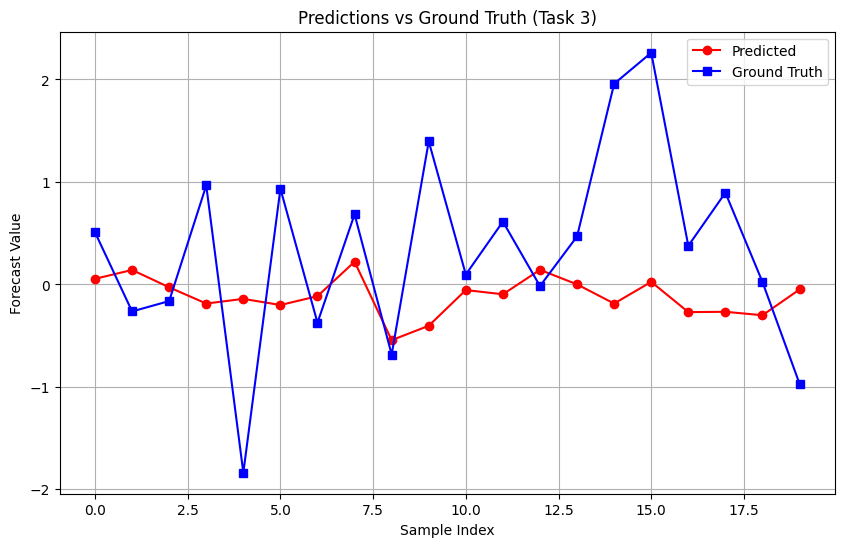

In [10]:
# ----- Hyperparameters -----

d_model = 32
nhead = 4
d_ff = 128
num_private_layers = 2
num_tasks = 10
dropout = 0.1

# ----- Instantiate Models -----

model = GeneralGlobalSharingMTL(d_model, nhead, d_ff, num_private_layers, num_tasks, dropout)
forecast_head = ForecastHead(d_model, out_dim=1)

# ----- Optimizer and Loss Functions -----

optimizer = torch.optim.Adam(list(model.parameters()) + list(forecast_head.parameters()), lr=1e-3)
criterion_mse = nn.MSELoss()    # For training loss (L2)
criterion_mae = nn.L1Loss()     # For reporting MAE

# ----- Training Loop -----

num_epochs = 5
seq_len = 15
batch_size = 64

for epoch in range(num_epochs):
    # Randomly select a task for each iteration
    task_id = torch.randint(0, num_tasks, (1,)).item()
    
    # Generate dummy input data: shape (seq_len, batch_size, d_model)
    x = torch.randn(seq_len, batch_size, d_model)
    # Dummy target: for single-step forecasting, shape (batch_size, 1)
    y_true = torch.randn(batch_size, 1)
    
    optimizer.zero_grad()
    z = model(x, task_id)       # Process input through the multi-task model
    y_pred = forecast_head(z)   # Forecast the next step
    loss = criterion_mse(y_pred, y_true)
    loss.backward()
    optimizer.step()
    
    mae = criterion_mae(y_pred, y_true).item()
    print(f"Epoch {epoch+1}, Task {task_id}, MSE Loss: {loss.item():.4f}, MAE: {mae:.4f}")



# ----- Evaluation and Plotting Predictions -----

# For demonstration, we'll use a single batch from a fixed task.
task_id = 3  # For example, evaluate on task 3
x_test = torch.randn(seq_len, batch_size, d_model)
y_test = torch.randn(batch_size, 1)  # Dummy ground truth for test set

model.eval()
forecast_head.eval()

with torch.no_grad():
    z_test = model(x_test, task_id)
    y_pred_test = forecast_head(z_test)

# Calculate MAE on the test batch
test_mae = criterion_mae(y_pred_test, y_test).item()
print(f"\nTest MAE: {test_mae:.4f}")

# Plotting the predictions vs ground truth
# (For illustration, we plot a subset of the batch, say 20 samples)
num_plot = 20
pred_vals = y_pred_test[:num_plot].squeeze().cpu().numpy()
true_vals = y_test[:num_plot].squeeze().cpu().numpy()

plt.figure(figsize=(10, 6))
plt.plot(pred_vals, 'ro-', label='Predicted')
plt.plot(true_vals, 'bs-', label='Ground Truth')
plt.title(f'Predictions vs Ground Truth (Task {task_id})')
plt.xlabel('Sample Index')
plt.ylabel('Forecast Value')
plt.legend()
plt.grid(True)
plt.show()

Training Global Sharing MTL Model:
Epoch 1: MSE Loss = 1.2962, MAE = 0.9086
Epoch 2: MSE Loss = 0.8482, MAE = 0.7163
Epoch 3: MSE Loss = 1.0204, MAE = 0.8108
Epoch 4: MSE Loss = 0.7695, MAE = 0.7255
Epoch 5: MSE Loss = 1.3906, MAE = 0.9748

Training Single-Task Model:
Epoch 1: MSE Loss = 1.3106, MAE = 0.8932
Epoch 2: MSE Loss = 1.2591, MAE = 0.8814
Epoch 3: MSE Loss = 1.6408, MAE = 1.0469
Epoch 4: MSE Loss = 1.3222, MAE = 0.9295
Epoch 5: MSE Loss = 1.2965, MAE = 0.9576

Test Global Sharing MTL - MAE: 0.7744, MSE: 0.9649
Test Single-Task Model - MAE: 0.9436, MSE: 1.2714


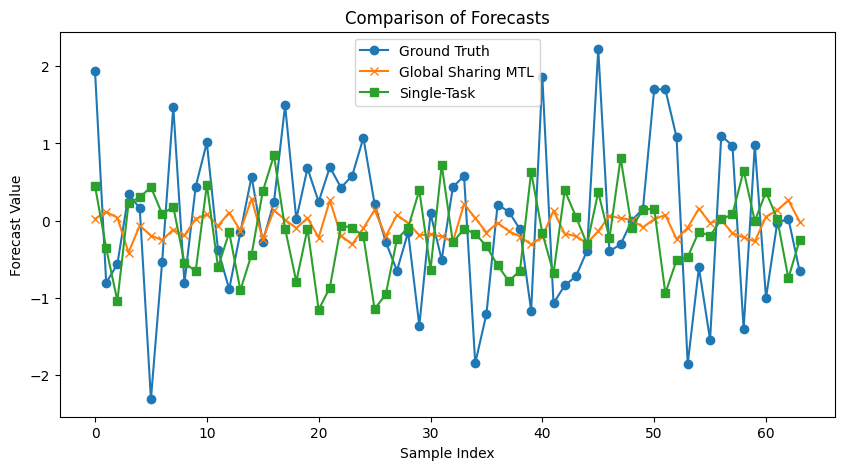

In [11]:
# -------------------------
# Evaluation & Plotting
# -------------------------

def evaluate(model, forecast_head, x, y_true, criterion_mae, criterion_mse):
    model.eval()
    forecast_head.eval()
    with torch.no_grad():
        z = model(x)
        y_pred = forecast_head(z)
        mae = criterion_mae(y_pred, y_true).item()
        mse = criterion_mse(y_pred, y_true).item()
    return y_pred, mae, mse

def plot_predictions(y_true, y_pred_global, y_pred_single):
    y_true_np = y_true.squeeze().cpu().numpy()
    y_pred_global_np = y_pred_global.squeeze().cpu().numpy()
    y_pred_single_np = y_pred_single.squeeze().cpu().numpy()
    
    plt.figure(figsize=(10, 5))
    plt.plot(y_true_np, label="Ground Truth", marker='o')
    plt.plot(y_pred_global_np, label="Global Sharing MTL", marker='x')
    plt.plot(y_pred_single_np, label="Single-Task", marker='s')
    plt.xlabel("Sample Index")
    plt.ylabel("Forecast Value")
    plt.title("Comparison of Forecasts")
    plt.legend()
    plt.show()

# -------------------------
# Main Code: Instantiate, Train, and Compare
# -------------------------

# Hyperparameters
d_model = 32
nhead = 4
d_ff = 128
num_layers = 2
dropout = 0.1
seq_len = 15
batch_size = 64
num_epochs = 5

# Instantiate models and forecast head(s)
global_model = GeneralGlobalSharingMTL(d_model, nhead, d_ff, num_layers, dropout)
single_model = SingleTaskModel(d_model, nhead, d_ff, num_layers, dropout)
forecast_head_global = ForecastHead(d_model, out_dim=1)
forecast_head_single = ForecastHead(d_model, out_dim=1)

# Optimizers and loss functions
optimizer_global = optim.Adam(list(global_model.parameters()) + list(forecast_head_global.parameters()), lr=1e-3)
optimizer_single = optim.Adam(list(single_model.parameters()) + list(forecast_head_single.parameters()), lr=1e-3)
criterion_mse = nn.MSELoss()
criterion_mae = nn.L1Loss()

# Dummy training loops (for demonstration)

print("Training Global Sharing MTL Model:")
for epoch in range(num_epochs):
    global_model.train()
    forecast_head_global.train()
    optimizer_global.zero_grad()
    
    # Dummy input and target (replace with your real data)
    x = torch.randn(seq_len, batch_size, d_model)
    y_true = torch.randn(batch_size, 1)
    
    z = global_model(x)
    y_pred = forecast_head_global(z)
    loss = criterion_mse(y_pred, y_true)
    loss.backward()
    optimizer_global.step()
    
    mae = criterion_mae(y_pred, y_true).item()
    print(f"Epoch {epoch+1}: MSE Loss = {loss.item():.4f}, MAE = {mae:.4f}")

print("\nTraining Single-Task Model:")
for epoch in range(num_epochs):
    single_model.train()
    forecast_head_single.train()
    optimizer_single.zero_grad()
    
    x = torch.randn(seq_len, batch_size, d_model)
    y_true = torch.randn(batch_size, 1)
    
    z = single_model(x)
    y_pred = forecast_head_single(z)
    loss = criterion_mse(y_pred, y_true)
    loss.backward()
    optimizer_single.step()
    
    mae = criterion_mae(y_pred, y_true).item()
    print(f"Epoch {epoch+1}: MSE Loss = {loss.item():.4f}, MAE = {mae:.4f}")

# -------------------------
# Evaluation & Plotting
# -------------------------

# Create dummy test data
x_test = torch.randn(seq_len, batch_size, d_model)
y_test = torch.randn(batch_size, 1)

# Evaluate both models on test data
y_pred_global, mae_global, mse_global = evaluate(global_model, forecast_head_global, x_test, y_test, criterion_mae, criterion_mse)
y_pred_single, mae_single, mse_single = evaluate(single_model, forecast_head_single, x_test, y_test, criterion_mae, criterion_mse)

print(f"\nTest Global Sharing MTL - MAE: {mae_global:.4f}, MSE: {mse_global:.4f}")
print(f"Test Single-Task Model - MAE: {mae_single:.4f}, MSE: {mse_single:.4f}")

# Plot both predictions in one plot
plot_predictions(y_test, y_pred_global, y_pred_single)


# EXPERIMENT RESULTS


==================== 🚀 RUN 1/1 ====================
🔀 Setting random seed: 4038
🔄 Training Multi-Task Learning (MTL) model...
Embedding size: 32
Train size: 1119 | Validation size: 279 | Test size: 350
Train size: 1119 | Validation size: 279 | Test size: 350
Train size: 1119 | Validation size: 279 | Test size: 350
Train size: 1119 | Validation size: 279 | Test size: 350
Train size: 1119 | Validation size: 279 | Test size: 350
Train size: 1119 | Validation size: 279 | Test size: 350
Train size: 1119 | Validation size: 279 | Test size: 350
Train size: 1119 | Validation size: 279 | Test size: 350
Train size: 1119 | Validation size: 279 | Test size: 350
Train size: 1119 | Validation size: 279 | Test size: 350
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


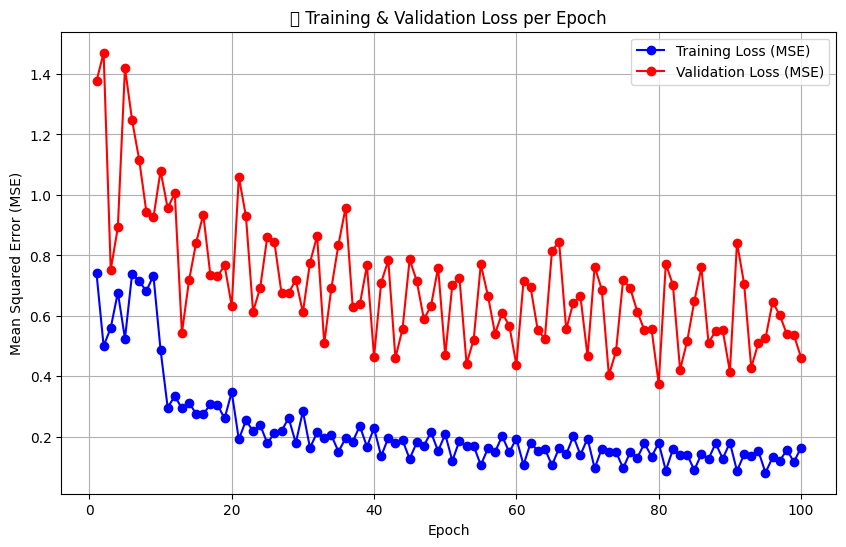

✅ Training completed!
Site 1 MAE: 0.2230
Site 2 MAE: 0.2365
Site 3 MAE: 0.1979
Site 4 MAE: 0.2060
Site 5 MAE: 0.2150
Site 6 MAE: 0.2633
Site 7 MAE: 0.2800
Site 8 MAE: 0.2487
Site 9 MAE: 0.1846
Site 10 MAE: 0.2554

Average MAE across all sites: 0.2310
✅ [RUN 1] MTL Average MAE: 0.2310

🔄 Training Single-Task Learning (STL) models per site...
🔀 Setting random seed: 4102
Embedding size: 32
Train size: 1119 | Validation size: 279 | Test size: 350
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


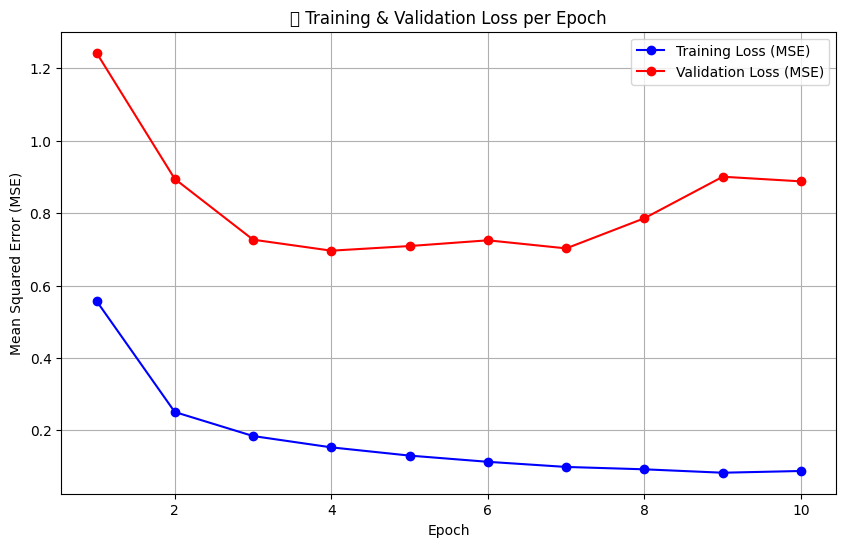

✅ Training completed!
Single-task model MAE: 0.2489
✅ [RUN 1] Site-1 STL MAE: 0.2489
🔀 Setting random seed: 8374
Embedding size: 32
Train size: 1119 | Validation size: 279 | Test size: 350
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


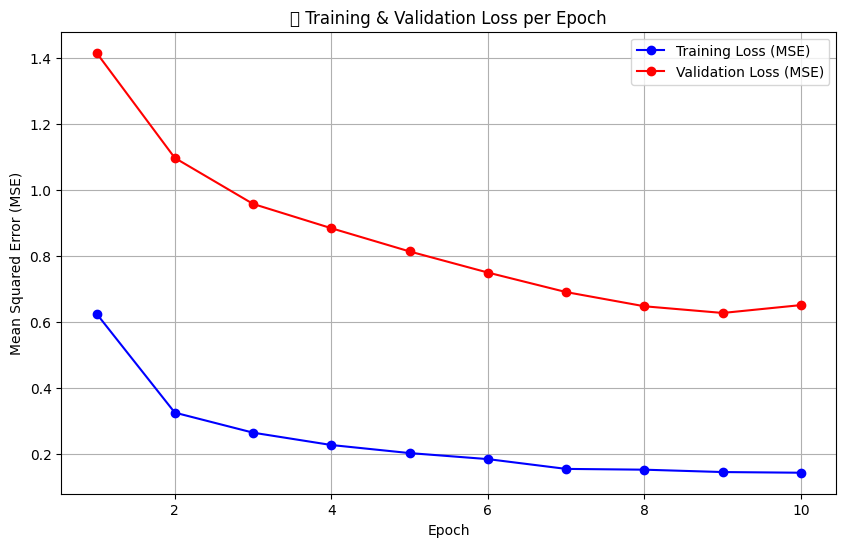

✅ Training completed!
Single-task model MAE: 0.2433
✅ [RUN 1] Site-2 STL MAE: 0.2433
🔀 Setting random seed: 3227
Embedding size: 32
Train size: 1119 | Validation size: 279 | Test size: 350
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


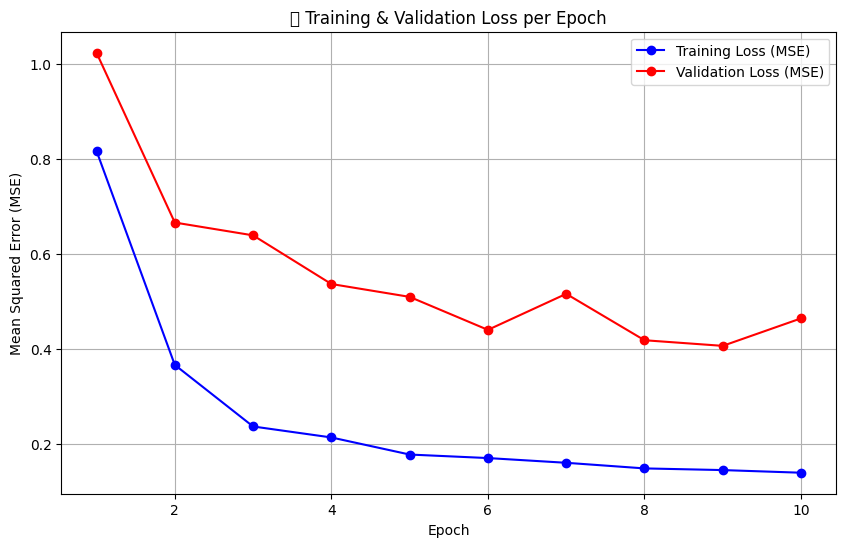

✅ Training completed!
Single-task model MAE: 0.2455
✅ [RUN 1] Site-3 STL MAE: 0.2455
🔀 Setting random seed: 5135
Embedding size: 32
Train size: 1119 | Validation size: 279 | Test size: 350
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


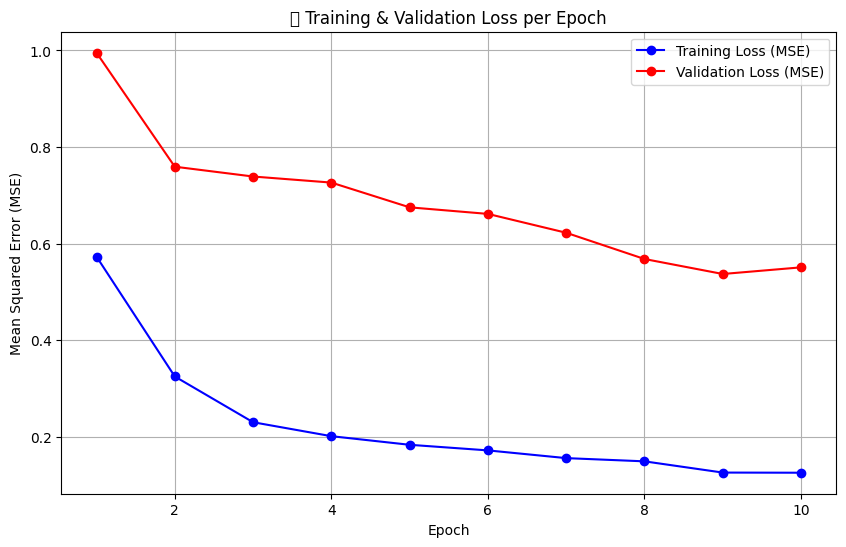

✅ Training completed!
Single-task model MAE: 0.2638
✅ [RUN 1] Site-4 STL MAE: 0.2638
🔀 Setting random seed: 4473
Embedding size: 32
Train size: 1119 | Validation size: 279 | Test size: 350
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


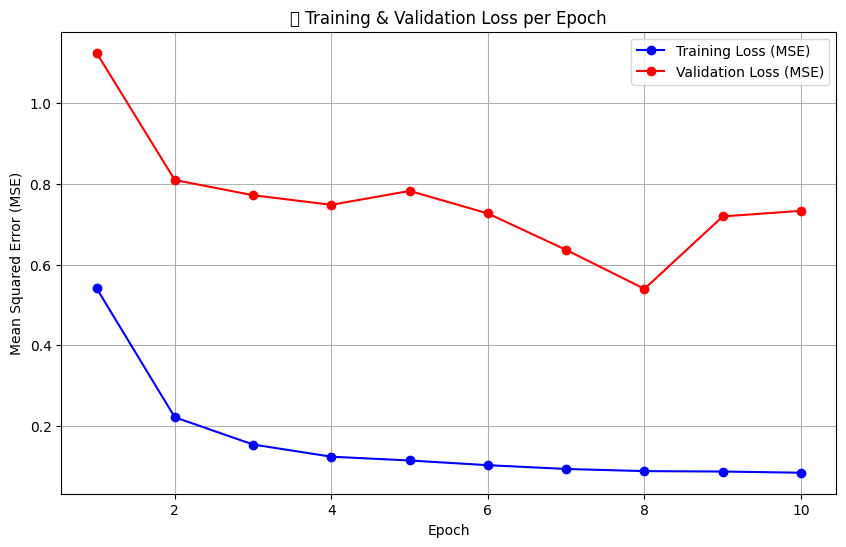

✅ Training completed!
Single-task model MAE: 0.2270
✅ [RUN 1] Site-5 STL MAE: 0.2270
🔀 Setting random seed: 4195
Embedding size: 32
Train size: 1119 | Validation size: 279 | Test size: 350
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


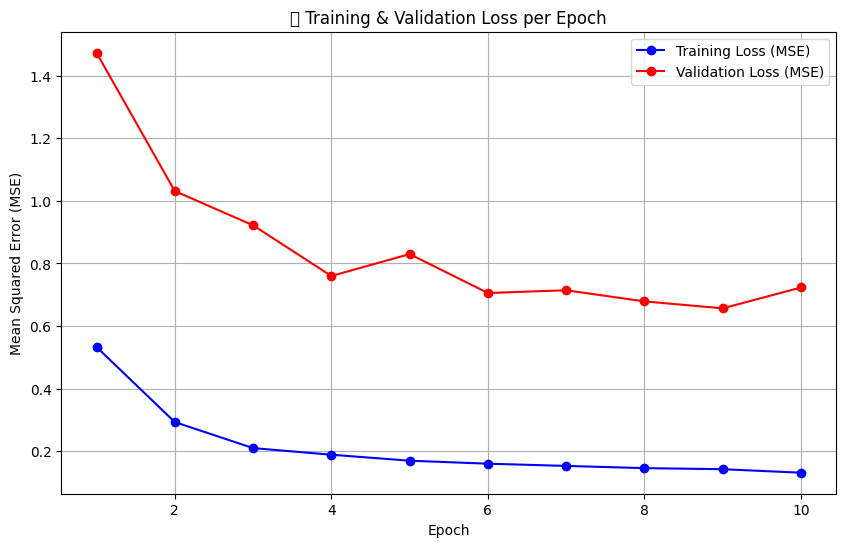

✅ Training completed!
Single-task model MAE: 0.2946
✅ [RUN 1] Site-6 STL MAE: 0.2946
🔀 Setting random seed: 2548
Embedding size: 32
Train size: 1119 | Validation size: 279 | Test size: 350
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


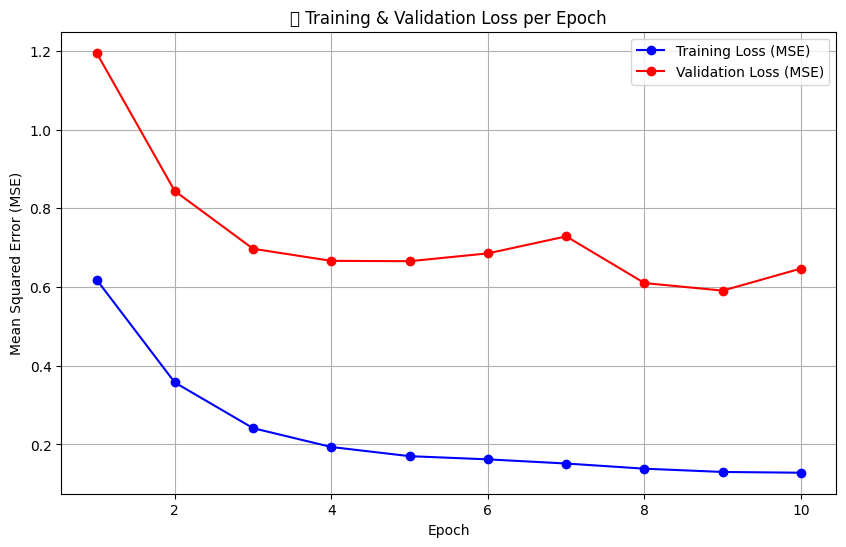

✅ Training completed!
Single-task model MAE: 0.3233
✅ [RUN 1] Site-7 STL MAE: 0.3233
🔀 Setting random seed: 4431
Embedding size: 32
Train size: 1119 | Validation size: 279 | Test size: 350
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


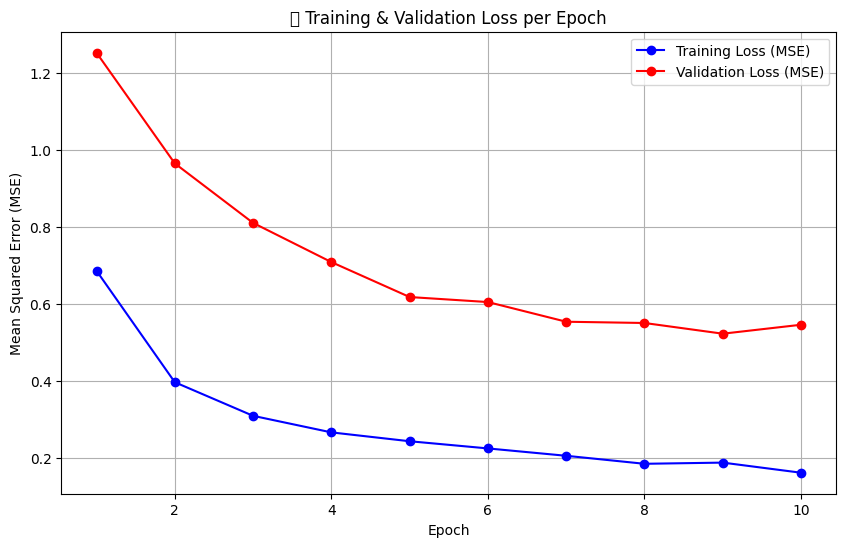

✅ Training completed!
Single-task model MAE: 0.2240
✅ [RUN 1] Site-8 STL MAE: 0.2240
🔀 Setting random seed: 3735
Embedding size: 32
Train size: 1119 | Validation size: 279 | Test size: 350
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


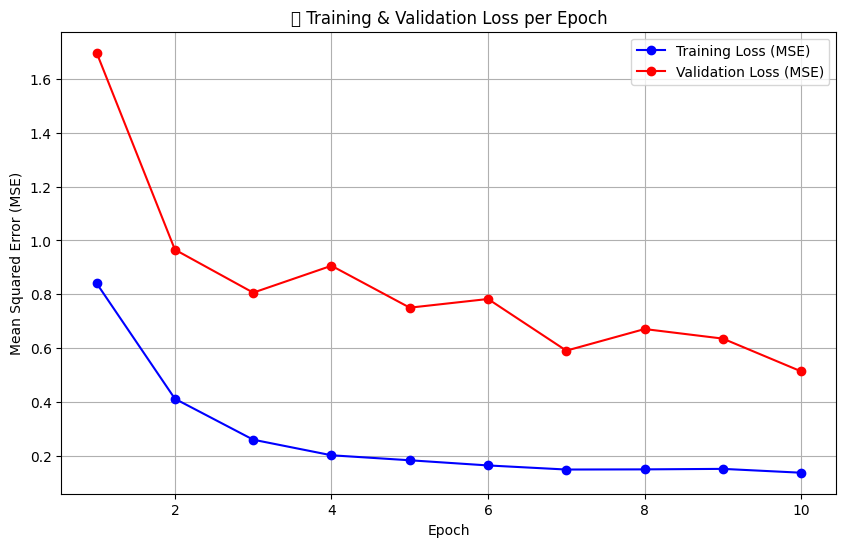

✅ Training completed!
Single-task model MAE: 0.1833
✅ [RUN 1] Site-9 STL MAE: 0.1833
🔀 Setting random seed: 7180
Embedding size: 32
Train size: 1119 | Validation size: 279 | Test size: 350
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


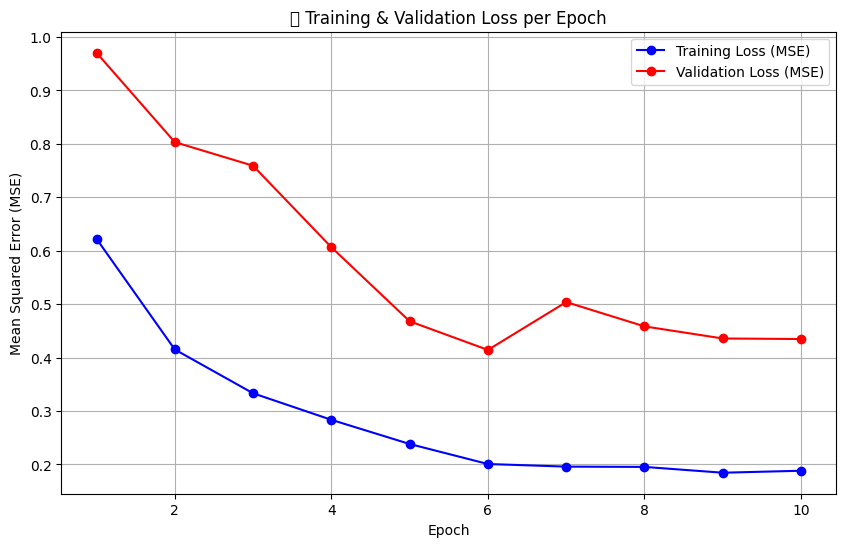

✅ Training completed!
Single-task model MAE: 0.2513
✅ [RUN 1] Site-10 STL MAE: 0.2513

==================== 📊 FINAL RESULTS ====================
🔥 Final STL per-site MAE: [0.24888718 0.24327582 0.24545401 0.26376122 0.22699651 0.29461291
 0.32329017 0.22397792 0.18330282 0.25126094]
🔥 Final MTL per-site MAE: [0.22301921 0.23649767 0.19789703 0.20599307 0.21495801 0.26333368
 0.27998146 0.24871837 0.18457475 0.25535446]
🌟 Final Average STL MAE across all sites: 0.2505
🌟 Final Average MTL MAE across all sites: 0.2310


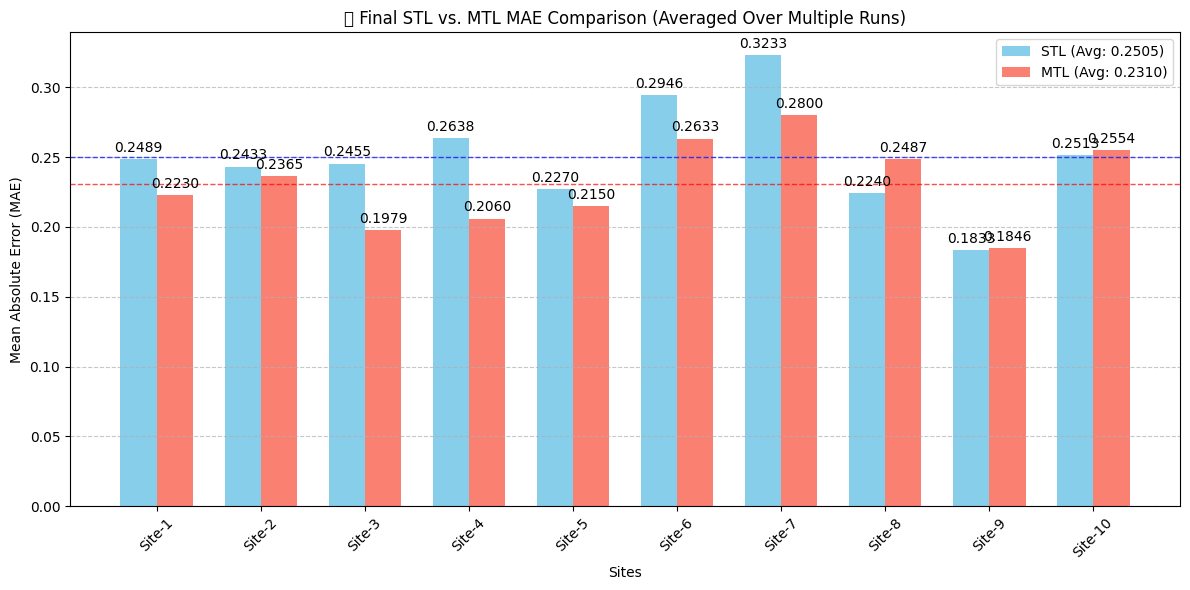

In [379]:
from sklearn.metrics import mean_absolute_error
import numpy as np
import torch
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


def evaluate_all_sites(model, forecast_head, site_loaders, device='cpu'):
    """
    Evaluates the trained MTL model on the test set for all sites and computes MAE for each site.
    """
    model.eval()
    forecast_head.eval()

    mae_list = []

    with torch.no_grad():
        for task_id, loaders in enumerate(site_loaders):
            _, _, test_loader = loaders
            all_preds, all_targets = [], []

            for X_test, y_test in test_loader:
                X_test, y_test = X_test.to(device), y_test.to(device)
                X_test = X_test.permute(1, 0, 2)
                # if X_test.shape[-1] != model.shared_attn.multihead_attn.embed_dim:
                    # X_test = X_test.repeat(1, 1, model.shared_attn.multihead_attn.embed_dim)

                z_test = model(X_test, task_id)
                y_pred_test = forecast_head(z_test).squeeze()

                all_preds.append(y_pred_test.cpu().numpy())
                all_targets.append(y_test.cpu().numpy())

            all_preds = np.concatenate(all_preds, axis=0)
            all_targets = np.concatenate(all_targets, axis=0)

            mae = mean_absolute_error(all_targets, all_preds)
            mae_list.append(mae)

    return mae_list, np.mean(mae_list)


def evaluate_all_sites_auto_reg(model, forecast_head, site_loaders, horizon=1, device='cpu'):
    """
    Evaluates the trained MTL model on the test set for all sites using multi-step autoregressive forecasting
    and computes MAE for each site.

    Args:
    - model: Trained GeneralGlobalSharingMTL model.
    - forecast_head: ForecastHead model.
    - site_loaders: List containing (train_loader, val_loader, test_loader) for all sites.
    - horizon: Number of future steps for multi-step forecasting.
    - device: 'cpu' or 'cuda'.

    Returns:
    - mae_list: List of MAE values for each site.
    - average_mae: Average MAE across all sites.
    """
    model.eval()
    forecast_head.eval()

    mae_list = []

    with torch.no_grad():
        for task_id, loaders in enumerate(site_loaders):
            _, _, test_loader = loaders
            all_preds, all_targets = [], []

            for X_test, y_test in test_loader:
                X_test, y_test = X_test.to(device), y_test.to(device)
                X_test = X_test.permute(1, 0, 2)  # (seq_len, batch_size, input_dim)

                # Prepare future exogenous variables for autoregressive prediction
                future_exog_test = X_test[-horizon:, :, 1:]  # Assuming target is at index 0

                # Multi-step autoregressive forecast
                y_pred_test = multi_step_forecast(model, forecast_head, X_test, future_exog_test, horizon, task_id, device)

                # Reshape y_test for consistency
                y_test = y_test.view(y_test.shape[0], horizon, -1)

                all_preds.append(y_pred_test.cpu().numpy())
                all_targets.append(y_test.cpu().numpy())

            # Concatenate all batches
            all_preds = np.concatenate(all_preds, axis=0)
            all_targets = np.concatenate(all_targets, axis=0)
            
            # Reshape to (batch_size * horizon, out_dim) for sklearn compatibility
            all_preds = all_preds.reshape(-1, all_preds.shape[-1])
            all_targets = all_targets.reshape(-1, all_targets.shape[-1])
            
            # Compute MAE for the current site
            mae = mean_absolute_error(all_targets, all_preds)
            mae_list.append(mae)
            print(f"Site {task_id + 1} MAE: {mae:.4f}")

    average_mae = np.mean(mae_list)
    print(f"\nAverage MAE across all sites: {average_mae:.4f}")
    
    return mae_list, average_mae



def train_single_task_model(site_path, features, target, num_epochs, batch_size, d_model, device, horizon = 1 ,lr=1 ,max_grad_norm=1, decay_rate=1, decay_step_size=1):
    """
    Trains a single-task model for a given site and returns the trained model, forecast head, and test loader.
    """
    model, forecast_head, site_loaders = train_mtl_model(
        [site_path], num_epochs=num_epochs, batch_size=batch_size, horizon=horizon ,d_model=d_model, features = features, target = target ,device=device, lr=lr ,max_grad_norm=max_grad_norm, decay_rate=decay_rate, decay_step_size=decay_step_size
    )
    return model, forecast_head, site_loaders[0][2]


def evaluate_single_task(model, forecast_head, test_loader, device='cpu'):
    """
    Evaluates the trained single-task model on the test set and computes MAE.
    """
    model.eval()
    forecast_head.eval()

    all_preds, all_targets = [], []

    with torch.no_grad():
        for X_test, y_test in test_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            X_test = X_test.permute(1, 0, 2)
            # if X_test.shape[-1] != model.shared_attn.multihead_attn.embed_dim:
            #     X_test = X_test.repeat(1, 1, model.shared_attn.multihead_attn.embed_dim)

            z_test = model(X_test, 0)
            y_pred_test = forecast_head(z_test).squeeze()

            all_preds.append(y_pred_test.cpu().numpy())
            all_targets.append(y_test.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    return mean_absolute_error(all_targets, all_preds)


def evaluate_single_task_auto_reg(model, forecast_head, test_loader, horizon=1, device='cpu'):
    """
    Evaluates the trained single-task model on the test set using multi-step autoregressive forecasting
    and computes the Mean Absolute Error (MAE).

    Args:
    - model: Trained single-task model.
    - forecast_head: ForecastHead used for prediction.
    - test_loader: PyTorch DataLoader for the test set.
    - horizon: Number of future steps for multi-step forecasting.
    - device: 'cpu' or 'cuda'.

    Returns:
    - mae: Mean Absolute Error across the test set.
    """
    model.eval()
    forecast_head.eval()

    all_preds, all_targets = [], []

    with torch.no_grad():
        for X_test, y_test in test_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            X_test = X_test.permute(1, 0, 2)  # (seq_len, batch_size, input_dim)

            # Prepare future exogenous variables (assuming target at index 0)
            future_exog_test = X_test[-horizon:, :, 1:]

            # Perform multi-step autoregressive forecasting
            y_pred_test = multi_step_forecast(model, forecast_head, X_test, future_exog_test, horizon, task_id=0, device=device)

            # Reshape y_test for multi-step comparison
            y_test = y_test.view(y_test.shape[0], horizon, -1)

            all_preds.append(y_pred_test.cpu().numpy())
            all_targets.append(y_test.cpu().numpy())
            


    # Concatenate all predictions and targets
    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    
    # Reshape to (batch_size * horizon, out_dim) for sklearn compatibility
    all_preds = all_preds.reshape(-1, all_preds.shape[-1])
    all_targets = all_targets.reshape(-1, all_targets.shape[-1])

    # Compute and return MAE
    mae = mean_absolute_error(all_targets, all_preds)
    print(f"Single-task model MAE: {mae:.4f}")
    return mae


import random


def set_random_seed(seed=None):
    """
    Sets random seeds for numpy, torch, and random to ensure randomness per run.
    If seed is None, generates a random seed.
    """
    if seed is None:
        seed = random.randint(0, 10000)
    print(f"🔀 Setting random seed: {seed}")

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True  # Enables randomness in CUDA backend


def run_experiments(base_path, num_runs=5, num_epochs=10, horizon = 1 ,lr=1e-3, max_grad_norm=0.5, decay_rate=0.85, decay_step_size=1 ,batch_size=32, d_model=32, device='cpu', features=[], target=''):
    """
    Runs STL and MTL experiments multiple times and computes average MAE results with full randomness per run.
    """
    site_paths = [f'{base_path}/site-{i}/site-{i}.csv' for i in range(3, 13)]
    total_sites = len(site_paths)

    # Initialize storage for MAEs
    stl_mae_runs = np.zeros((num_runs, total_sites))
    mtl_mae_runs = np.zeros((num_runs, total_sites))

    # Run experiments
    for run in range(num_runs):
        print(f"\n==================== 🚀 RUN {run + 1}/{num_runs} ====================")
        
        # ✅ Ensure randomness per run
        set_random_seed()

        # MTL training and evaluation
        print("🔄 Training Multi-Task Learning (MTL) model...")
        model, forecast_head, site_loaders = train_mtl_model(
            site_paths, num_epochs=num_epochs, horizon=horizon ,lr=lr ,batch_size=batch_size, d_model=d_model,
            device=device, features=features, target=target, max_grad_norm=max_grad_norm, 
            decay_rate=decay_rate, decay_step_size=decay_step_size
        )
        mtl_mae_list, mtl_avg_mae = evaluate_all_sites_auto_reg(model, forecast_head, site_loaders, horizon, device)
        mtl_mae_runs[run, :] = mtl_mae_list
        print(f"✅ [RUN {run + 1}] MTL Average MAE: {mtl_avg_mae:.4f}")

        # STL training and evaluation
        print("\n🔄 Training Single-Task Learning (STL) models per site...")
        for site_id, site_path in enumerate(site_paths, start=1):
            set_random_seed()  # ✅ Ensuring randomness even per site training
            model_stl, forecast_head_stl, test_loader_stl = train_single_task_model(
                site_path, num_epochs=num_epochs, batch_size=batch_size, horizon = horizon,
                d_model=d_model, device=device, features=features, target=target,
                max_grad_norm=max_grad_norm, decay_rate=decay_rate, decay_step_size=decay_step_size, lr=lr
            )
            stl_mae = evaluate_single_task_auto_reg(model_stl, forecast_head_stl, test_loader_stl, horizon ,device=device)
            stl_mae_runs[run, site_id - 1] = stl_mae
            print(f"✅ [RUN {run + 1}] Site-{site_id} STL MAE: {stl_mae:.4f}")

    # Compute final average results across all runs
    avg_stl_per_site = np.mean(stl_mae_runs, axis=0)
    avg_mtl_per_site = np.mean(mtl_mae_runs, axis=0)
    avg_stl_overall = np.mean(avg_stl_per_site)
    avg_mtl_overall = np.mean(avg_mtl_per_site)

    print("\n==================== 📊 FINAL RESULTS ====================")
    print(f"🔥 Final STL per-site MAE: {avg_stl_per_site}")
    print(f"🔥 Final MTL per-site MAE: {avg_mtl_per_site}")
    print(f"🌟 Final Average STL MAE across all sites: {avg_stl_overall:.4f}")
    print(f"🌟 Final Average MTL MAE across all sites: {avg_mtl_overall:.4f}")

    # Plotting comparison
    plot_stl_vs_mtl(avg_stl_per_site, avg_mtl_per_site, avg_stl_overall, avg_mtl_overall)


def plot_stl_vs_mtl(stl_mae, mtl_mae, avg_stl, avg_mtl):
    """
    Plots the final average STL vs. MTL MAE per site after multiple runs.
    """
    sites = [f"Site-{i}" for i in range(1, len(stl_mae) + 1)]
    x = np.arange(len(sites))
    width = 0.35

    plt.figure(figsize=(12, 6))
    bars1 = plt.bar(x - width / 2, stl_mae, width, label=f'STL (Avg: {avg_stl:.4f})', color='skyblue')
    bars2 = plt.bar(x + width / 2, mtl_mae, width, label=f'MTL (Avg: {avg_mtl:.4f})', color='salmon')

    plt.ylabel('Mean Absolute Error (MAE)')
    plt.xlabel('Sites')
    plt.title('📊 Final STL vs. MTL MAE Comparison (Averaged Over Multiple Runs)')
    plt.xticks(x, sites, rotation=45)
    plt.legend()

    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            plt.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                         xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

    plt.axhline(y=avg_stl, color='blue', linestyle='--', linewidth=1, alpha=0.7)
    plt.axhline(y=avg_mtl, color='red', linestyle='--', linewidth=1, alpha=0.7)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


# 🚀 **Run the complete experiment with multiple runs**
features = ['PM2.5', 'OT', 'PM10', 'NO2']
target = 'PM2.5'
base_path = '../processed_ds/air_quality_cluster'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 0.0003
max_grad_norm=0.7
decay_rate=0.99
decay_step_size=1
window_size = 32
horizon = 4
run_experiments(base_path, num_runs=1, num_epochs=10, horizon=horizon, batch_size=64, d_model=32, lr=lr, max_grad_norm=max_grad_norm, decay_rate=decay_rate, decay_step_size=decay_step_size ,device=device, features = features, target = target)


In [284]:
torch.cuda.empty_cache

<function torch.cuda.memory.empty_cache() -> None>